In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, pickle, joblib, zuko
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
import logging
import torch
import torch.nn as nn
import seaborn as sns
import time

from ili.embedding import FCN
from sklearn.model_selection import train_test_split
import scipy
from ili.utils.ndes_pt import LampeEnsemble

from funcs import *
from zuko import lazy
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [3]:
import glob
glob.glob('/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/*/diag/galaxies/*_wst.h5')

['/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07053_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07052_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07051_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07054_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07055_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/338/diag/galaxies/hod03384_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/338/diag/galaxies/hod03383_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/338/diag/galaxies/hod03381_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/338/diag/galaxies/hod03382_wst.h5',
 '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/338/diag/galaxies/hod03385_wst.h5',
 '/anvil/s

In [2]:
dir_path3='/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/'
train_x3, train_theta3 = np.load(dir_path3+'x_train.npy'), np.load(dir_path3+'theta_train.npy')
test_x3, test_theta3 = np.load(dir_path3+'x_test.npy'), np.load(dir_path3+'theta_test.npy')
ensemble3 = torch.load(dir_path3+'nets/posterior_top10.pth')

nbody_path3 = "/anvil/scratch/x-abairagi/cmass-ili/abacus/nbody/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/"
test_nbody_x3, test_nbody_theta3, ids_nbody_theta3 = np.load(nbody_path3+'x_test.npy'), np.load(nbody_path3+'theta_test.npy'), np.load(nbody_path3+'ids_test.npy')

test_x3=normalize(train_x3, test_x3)
test_nbody_x3=normalize(train_x3, test_nbody_x3)

In [3]:
dir_path2='/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zwst/'
train_x2, train_theta2 = np.load(dir_path2+'x_train.npy'), np.load(dir_path2+'theta_train.npy')
test_x2, test_theta2 = np.load(dir_path2+'x_test.npy'), np.load(dir_path2+'theta_test.npy')
ensemble2 = torch.load(dir_path2+'nets/posterior_top10.pth')

nbody_path2 = "/anvil/scratch/x-abairagi/cmass-ili/abacus/nbody/models/halo/zwst/"
test_nbody_x2, test_nbody_theta2, ids_nbody_theta2 = np.load(nbody_path2+'x_test.npy'), np.load(nbody_path2+'theta_test.npy'), np.load(nbody_path2+'ids_test.npy')

test_x2=normalize(train_x2, test_x2)
test_nbody_x2=normalize(train_x2, test_nbody_x2)

In [4]:
dir_path1='/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/'
train_x1, train_theta1 = np.load(dir_path1+'x_train.npy'), np.load(dir_path1+'theta_train.npy')
test_x1, test_theta1 = np.load(dir_path1+'x_test.npy'), np.load(dir_path1+'theta_test.npy')
ensemble1 = pickle.load(open(dir_path1+'posterior.pkl', 'rb'))

nbody_path1 = "/anvil/scratch/x-abairagi/cmass-ili/abacus/nbody/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/"
test_nbody_x1, test_nbody_theta1 = np.load(nbody_path1+'x_test.npy'), np.load(nbody_path1+'theta_test.npy')


In [5]:
samples3=generate_sample(ensemble3, test_nbody_x3[0], 1000, device)
samples2=generate_sample(ensemble2, test_nbody_x2[0], 1000, device)
samples1=generate_sample(ensemble1, test_nbody_x1[0], 1000, device)

INFO:root:Sampling models with tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]) samples each.
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 175it [00:00, 2824.91it/s]             
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 174it [00:00, 330.38it/s]                        
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 167it [00:00, 5946.14it/s]             
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 182it [00:00, 3877.60it/s]             
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 188it [00:00, 3781.79it/s]             
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples: 182it [00:00, 31299.49it/s]            
INFO:root:Sampling models with tensor([100.]) samples each.
Drawing 100 posterior samples:

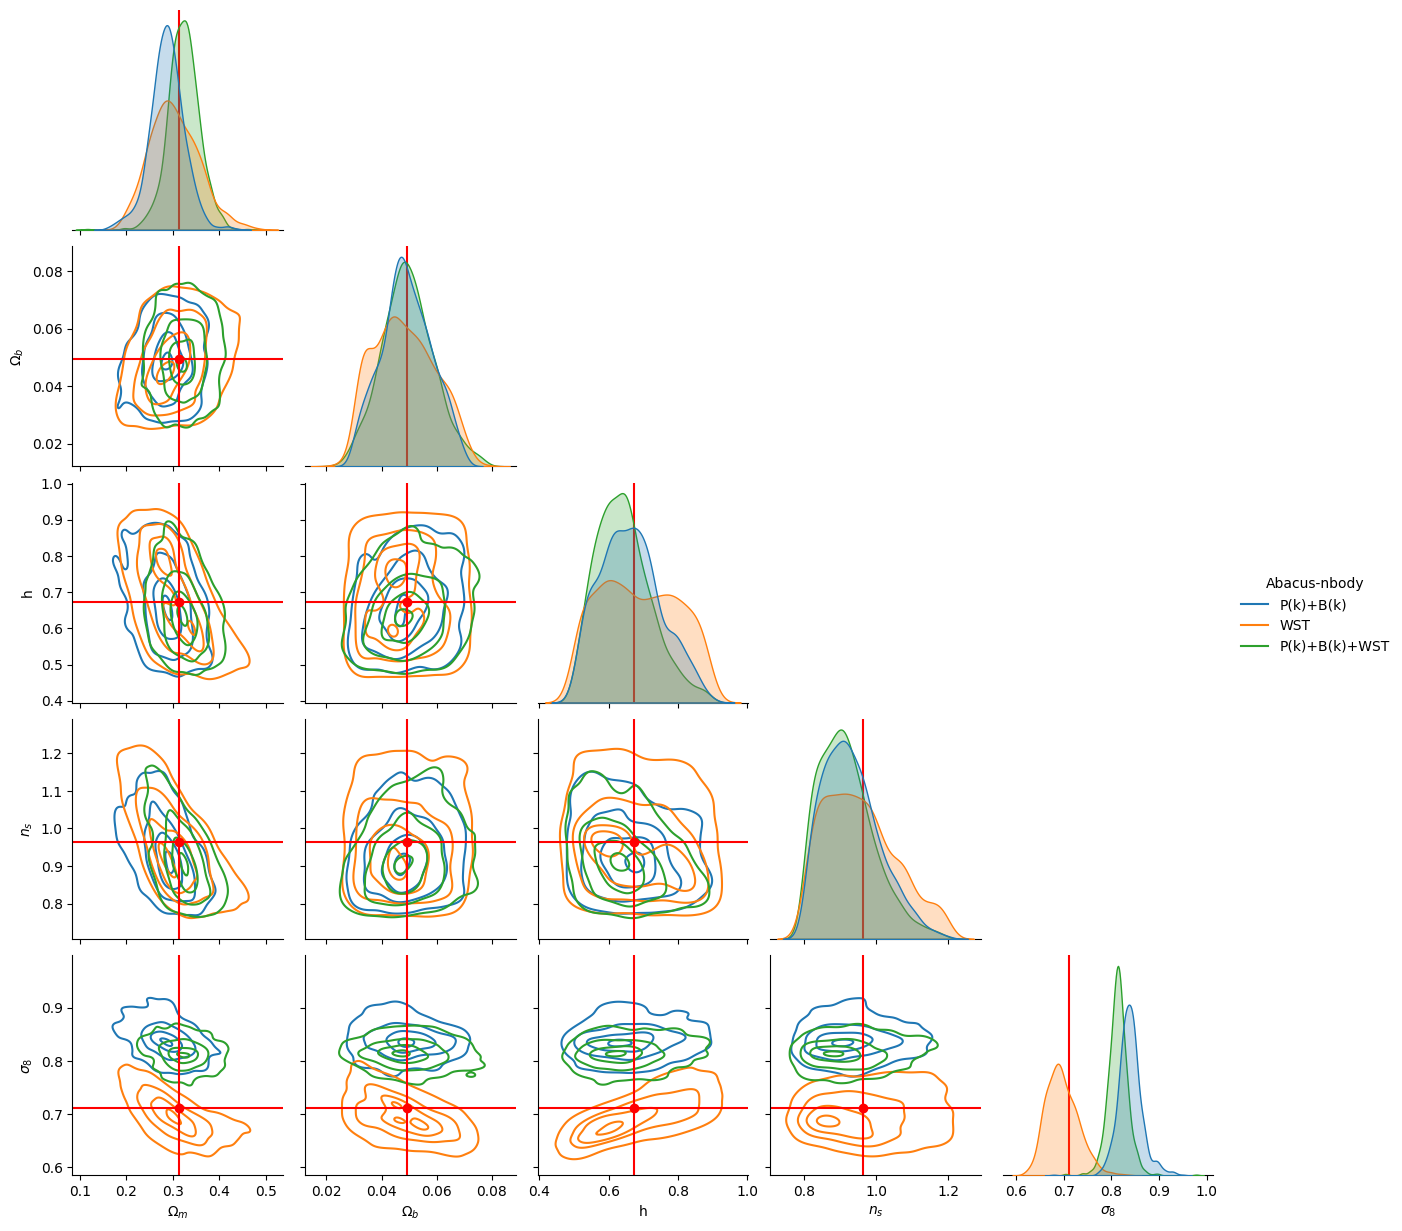

In [6]:
nbody="Abacus-nbody"
ind=0
df1=pd.DataFrame(samples1, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df2=pd.DataFrame(samples2, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df3=pd.DataFrame(samples3, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df1[nbody]="P(k)+B(k)"
df2[nbody]="WST"
df3[nbody]="P(k)+B(k)+WST"
df = pd.concat([df1, df2, df3])
theta = test_nbody_theta2[ind]
fig=sns.pairplot(df, kind="kde", corner=True, hue=nbody, plot_kws=dict(common_norm=False, levels=[0.05, 0.32, 0.68, 0.95]))
    
for i in range(5):
    for j in range(i + 1):
        if i == j:
            fig.axes[i, i].axvline(theta[i], color="r")
        else:
            fig.axes[i, j].axhline(theta[i], color="r")
            fig.axes[i, j].axvline(theta[j], color="r")
            fig.axes[i, j].plot(theta[j], theta[i], "ro")
            

In [9]:
test_nbody_theta3[0]-test_nbody_theta2[0]

array([0., 0., 0., 0., 0.])

100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
INFO:root:Mean logprob: -1.5024e+02Median logprob: -3.2585e+01
100%|██████████| 100/100 [00:00<00:00, 688.22it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


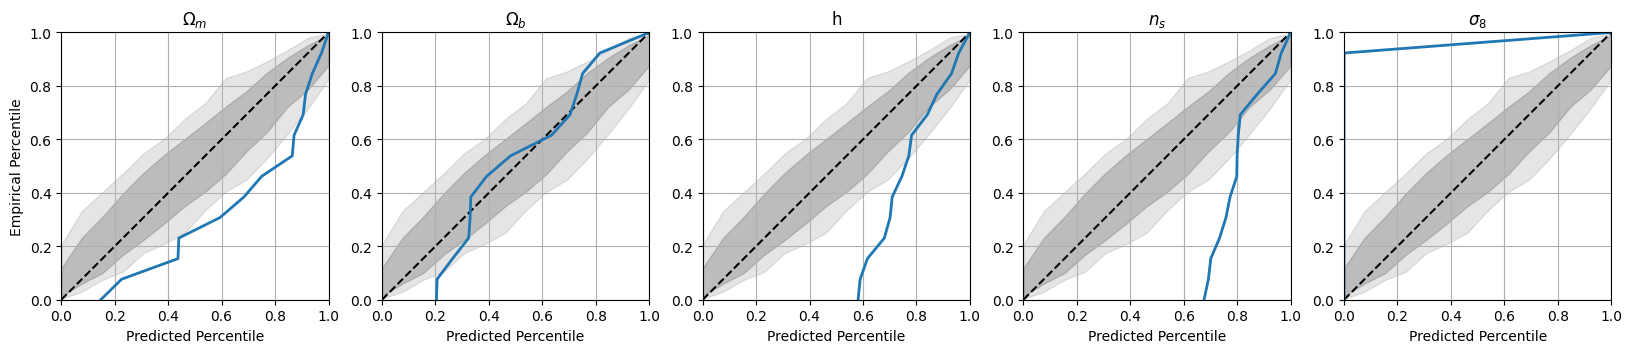

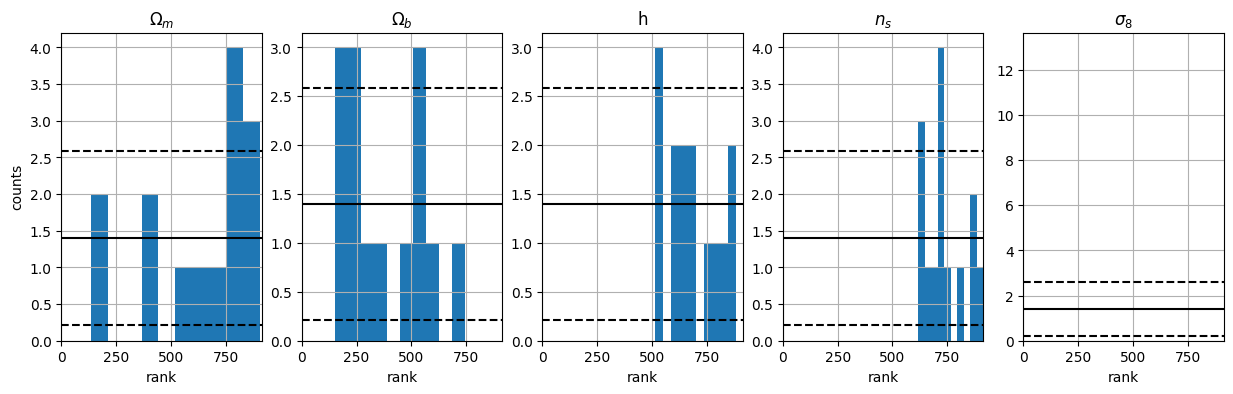

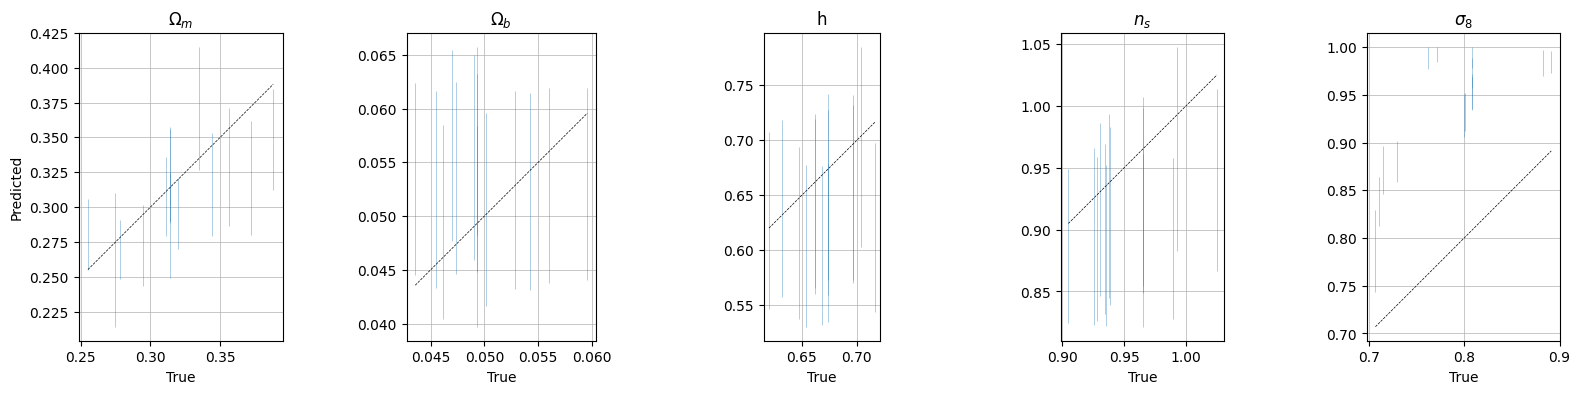

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


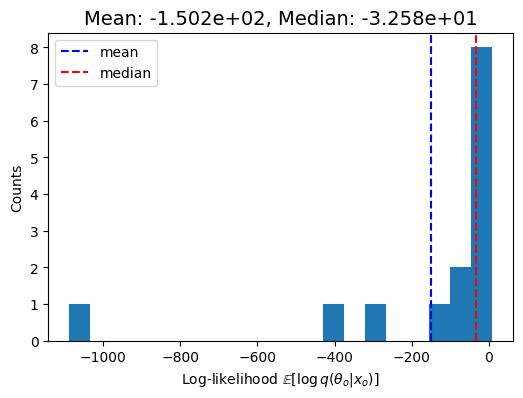

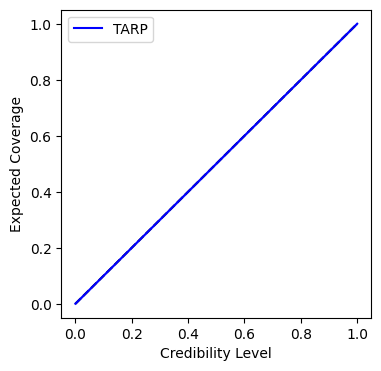

In [11]:
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=ensemble1,
#     .posteriors[0],
    x=test_nbody_x1[[0,1,2,4,5,6,7,9,10,11,13,14,15,17]], theta=test_nbody_theta1[[0,1,2,4,5,6,7,9,10,11,13,14,15,17]]
)

100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
INFO:root:Mean logprob: 7.7693e+00Median logprob: 7.9796e+00
100%|██████████| 100/100 [00:00<00:00, 530.73it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


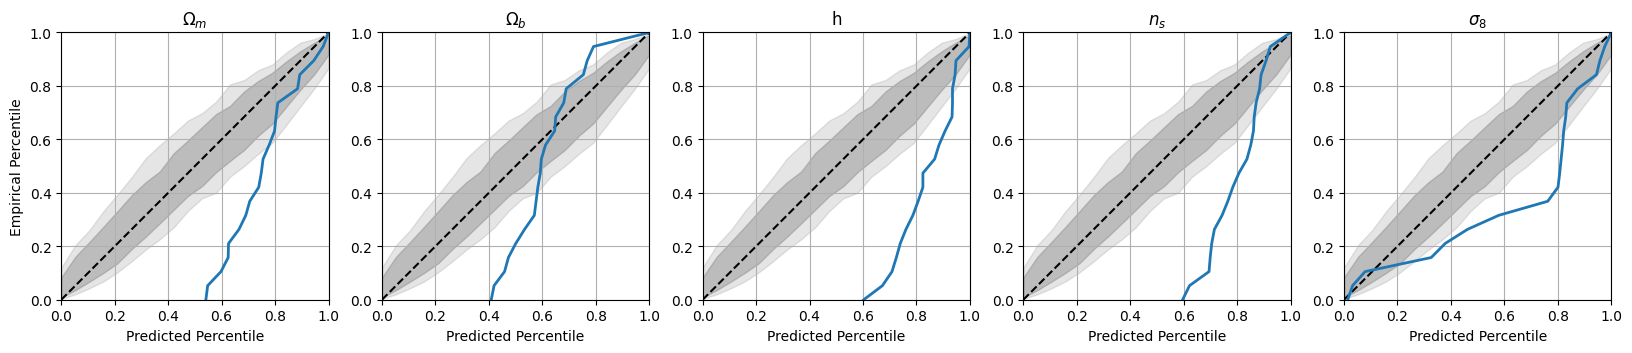

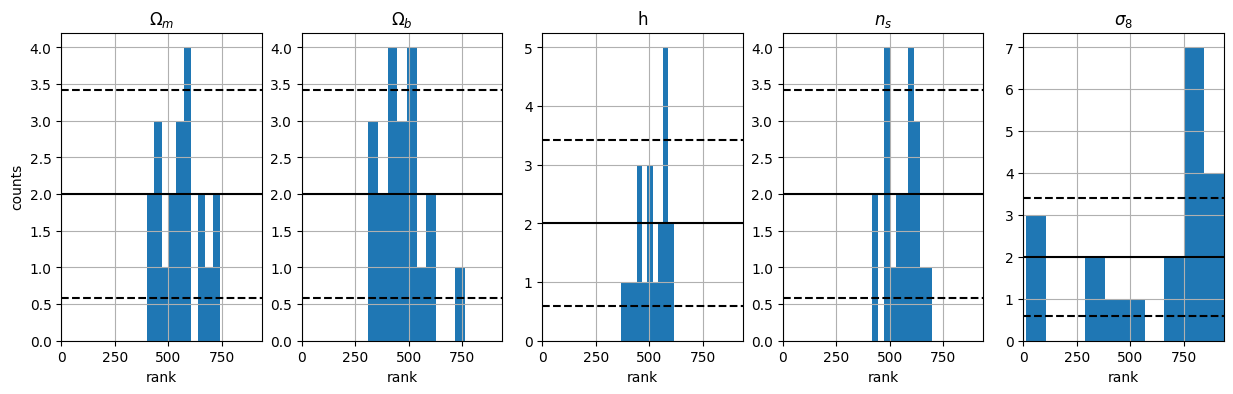

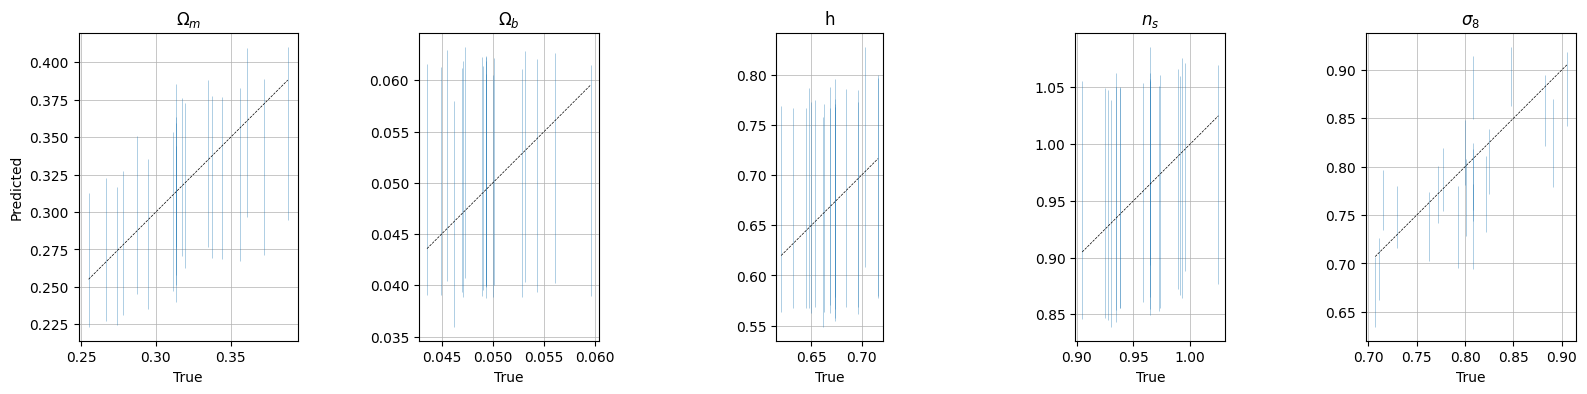

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


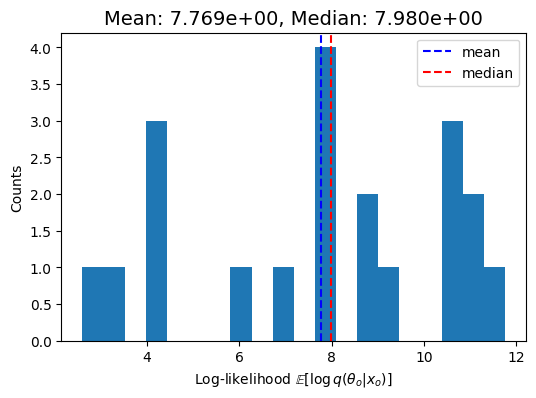

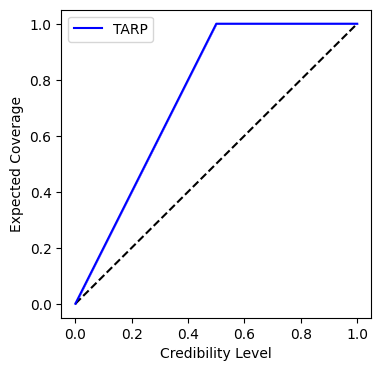

In [7]:
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=ensemble2,
#     .posteriors[0],
    x=test_nbody_x2, theta=test_nbody_theta2
)

100%|██████████| 100/100 [00:00<00:00, 476.20it/s]


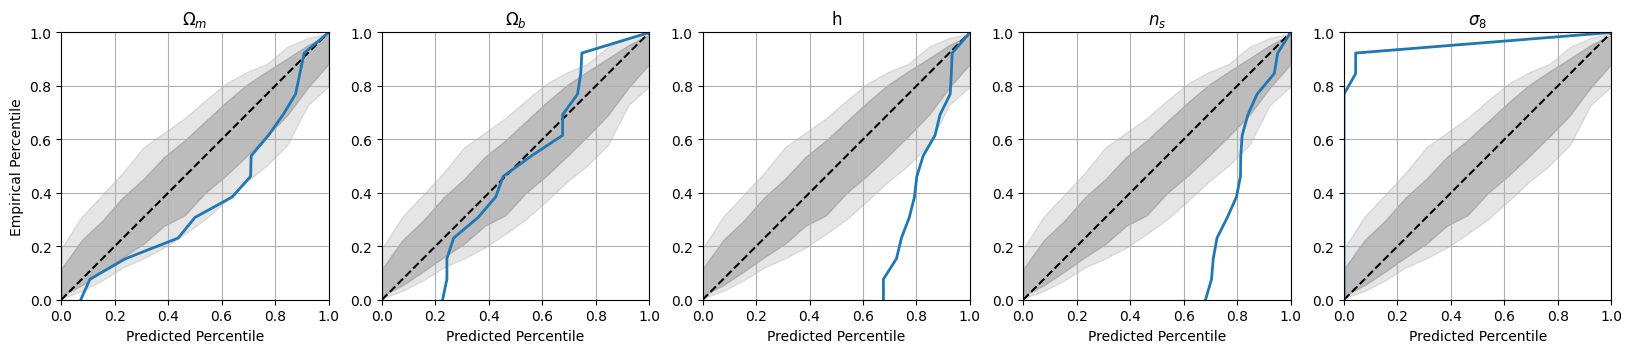

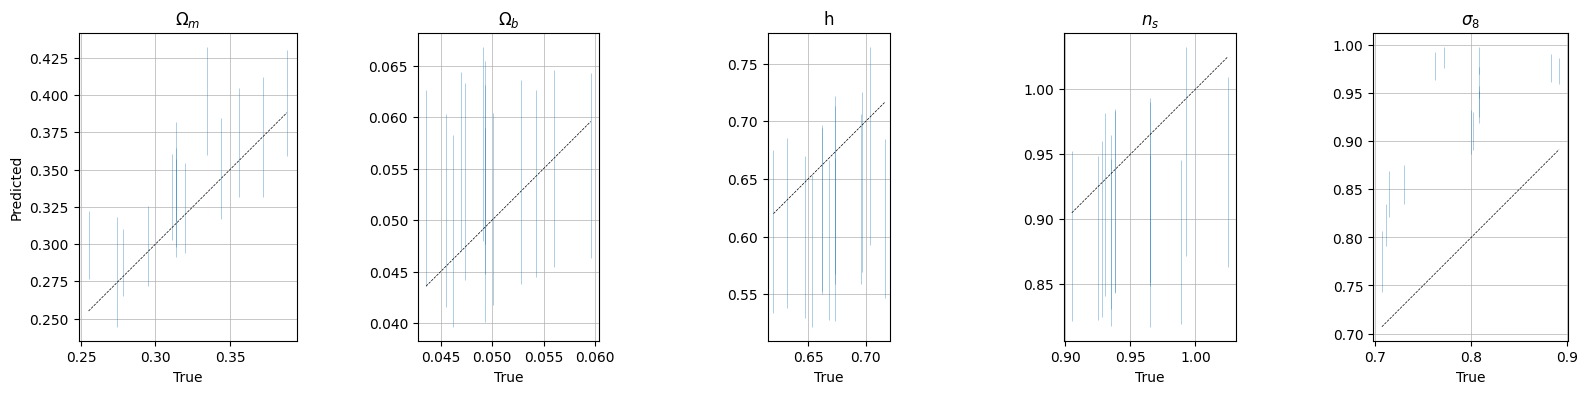

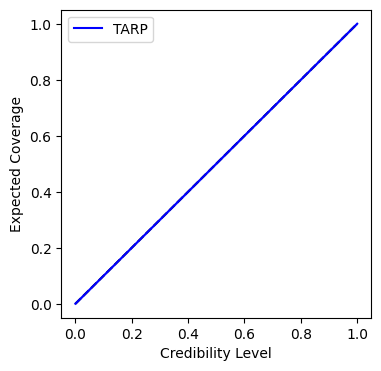

In [8]:
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "predictions", "tarp"])

fig = metric(
    posterior=ensemble3,
#     .posteriors[0],
    x=test_nbody_x3[[0,1,2,4,5,6,7,9,10,11,13,14,15,17]], theta=test_nbody_theta3[[0,1,2,4,5,6,7,9,10,11,13,14,15,17]]
)